In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [107]:
from DataLoader import Rescale, EyeDataSet, show_batch 

ImportError: cannot import name 'Rescale' from 'DataLoader' (d:\Nauka\Polibuda\Inżynierka\Eye-Diesese-ML\DataLoader.py)

In [18]:
scale = Rescale((224,224))

In [88]:
transformed_dataset = EyeDataLSet('./data/dataset.csv','./data/train_data/compressed',transform=scale)
dataloader = DataLoader(transformed_dataset, batch_size=16,shuffle=True, num_workers=0)

0 torch.Size([16, 224, 224, 3])


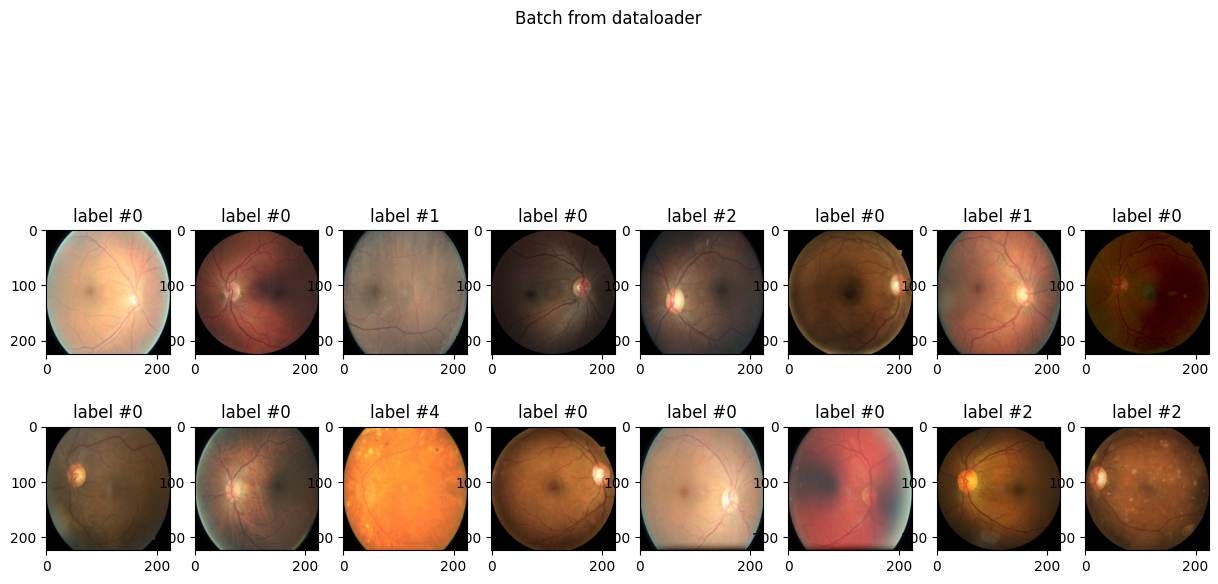

In [104]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 0:
        show_batch(sample_batched)
        break

image name:./data/train_data/compressed/10_left.jpeg, image shape(224, 224, 3)
transformed image shape(224, 224, 3)


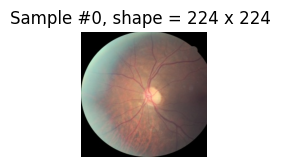

image name:./data/train_data/compressed/10_right.jpeg, image shape(224, 224, 3)
transformed image shape(224, 224, 3)


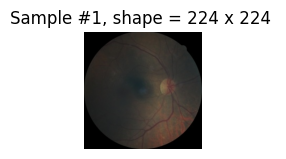

image name:./data/train_data/compressed/13_left.jpeg, image shape(224, 224, 3)
transformed image shape(224, 224, 3)


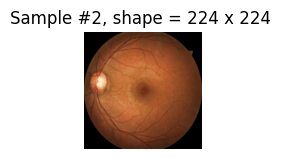

image name:./data/train_data/compressed/13_right.jpeg, image shape(224, 224, 3)
transformed image shape(224, 224, 3)


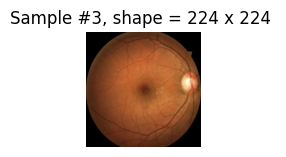

In [120]:
fig = plt.figure()


for i,dict in enumerate(transformed_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}, shape = {dict["image"].shape[0]} x {dict["image"].shape[1]} '.format(i))
    ax.axis('off')
    plt.imshow(dict['image'])
    plt.pause(0.001)
    
    if i == 3:
        plt.show()
        break

In [5]:
pd.read_csv('./data/dataset.csv').iloc[12,1]

'20_left.jpeg'

In [ ]:
EyeDataLoader('')